In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from angle_estimation_model import AngleDataset, AngleEstimationModel, train_epoch, evaluate_model, mean_shift, split_dataset
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)

Using mps


In [3]:
torch.manual_seed(0)

In [4]:
N = 24           # Number of orientations per task
M = 4               # Number of tasks (discretization)
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
IMG_SIZE = 224


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_dir = "/Users/vlad.sarm/Documents/sausage_rotation_estimation/data"  # Update this path to your dataset
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
raw_dir = os.path.join(data_dir, "by_degrees")

In [7]:
split_dataset(raw_dir, data_dir, val_ratio=0.1)

Dataset split complete: 5097 training images, 367 validation images


(5097, 367)

In [8]:
train_dataset = AngleDataset(
    root_dir=train_dir,
    transform=train_transforms,
    discretization_params={'N': N, 'M': M}
)

val_dataset = AngleDataset(
    root_dir=val_dir,
    transform=val_transforms,
    discretization_params={'N': N, 'M': M}
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 5097
Validation samples: 367


In [9]:
# Initialize model
model = AngleEstimationModel(N=N, M=M, feature_extract=False)  # Set feature_extract=False to fine-tune the whole model
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
TRAIN = True  # Set to False to skip training and load the model directly

if TRAIN:
    best_val_mae = float('inf')
    best_epoch = 0
    best_model_state = None

    val_mae_not_improved = 0
    patience = 4  # Number of epochs to wait for improvement before stopping

    print("Starting training...")
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mae, std_dev = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Std Dev: {std_dev:.4f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_epoch = epoch
            best_model_state = model.state_dict()
            val_mae_not_improved = 0

            print("Saving model...")
            save_path = f"rgb2_N-{N}_M-{M}"
            os.makedirs(save_path, exist_ok=True)
            prev = os.listdir(save_path)
            for file in prev:
                if file.endswith(".pth"):
                    os.remove(os.path.join(save_path, file))
            torch.save(model.state_dict(), f"{save_path}/MAE-{val_mae:.2f}_DEV-{std_dev:.2f}_EPOCH-{epoch+1}.pth")
        else:
            val_mae_not_improved += 1
            if val_mae_not_improved >= patience:
                print(f"Early stopping at epoch {epoch+1} with best validation MAE: {best_val_mae:.4f} at epoch {best_epoch+1}")
                break
else:
    checkpoint = torch.load("/Users/vlad.sarm/Documents/sausage_rotation_estimation/angle_recognition/rgb_N-24_M-4/MAE-3.96_DEV-14.66_EPOCH-7.pth", map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()


Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 6.0200, Train MAE: 35.2172
Val Loss: 1.0949, Val MAE: 5.2618, Std Dev: 17.9540
Saving model...


 10%|█         | 1/10 [03:13<29:00, 193.43s/it]

Epoch [2/10], Train Loss: 0.9778, Train MAE: 3.9890
Val Loss: 0.8421, Val MAE: 3.4208, Std Dev: 13.6267
Saving model...


 30%|███       | 3/10 [09:21<21:43, 186.16s/it]

Epoch [3/10], Train Loss: 0.7811, Train MAE: 3.5593
Val Loss: 0.7211, Val MAE: 3.5389, Std Dev: 15.9541


 40%|████      | 4/10 [12:27<18:36, 186.04s/it]

Epoch [4/10], Train Loss: 0.7253, Train MAE: 3.3747
Val Loss: 0.6245, Val MAE: 3.7465, Std Dev: 17.0015
Epoch [5/10], Train Loss: 0.6425, Train MAE: 3.1798
Val Loss: 0.5744, Val MAE: 3.3520, Std Dev: 15.3045
Saving model...


 60%|██████    | 6/10 [18:44<12:29, 187.45s/it]

Epoch [6/10], Train Loss: 0.5822, Train MAE: 3.0305
Val Loss: 0.5738, Val MAE: 3.7373, Std Dev: 16.7125
Epoch [7/10], Train Loss: 0.5458, Train MAE: 3.1076
Val Loss: 0.5315, Val MAE: 2.9769, Std Dev: 14.0650
Saving model...


 70%|███████   | 7/10 [21:52<09:22, 187.46s/it]

Epoch [8/10], Train Loss: 0.5086, Train MAE: 3.1249
Val Loss: 0.5430, Val MAE: 2.5032, Std Dev: 11.4176
Saving model...


 90%|█████████ | 9/10 [27:58<03:05, 185.02s/it]

Epoch [9/10], Train Loss: 0.4600, Train MAE: 3.0157
Val Loss: 0.6014, Val MAE: 3.7769, Std Dev: 17.0522


100%|██████████| 10/10 [31:00<00:00, 186.03s/it]

Epoch [10/10], Train Loss: 0.4544, Train MAE: 2.9027
Val Loss: 0.5460, Val MAE: 3.2218, Std Dev: 15.4597


In [11]:
print("Evaluating model...")
if TRAIN:
    model.load_state_dict(best_model_state)
    model.eval()
_, mae, std_dev = evaluate_model(model, val_loader, criterion, device)
print(f"Mean Absolute Error: {mae:.2f} degrees; Std Dev: {std_dev:.2f} degrees")

Evaluating model...
Mean Absolute Error: 3.22 degrees; Std Dev: 15.46 degrees


In [12]:
import numpy as np
from scipy.special import i0
def wrap(a):
    """Map angle to [0, 2π)."""
    return np.mod(a, 2 * np.pi)


def vonmises_kde_weighted(grid, angles, probs, kappa):
    """
    Weighted von-Mises KDE on the circle.

    grid   : (M,) evaluation points [rad]
    angles : (N,) discrete support angles [rad]
    probs  : (N,) probabilities,  Σp_i = 1
    kappa  : concentration
    """
    kern = np.exp(kappa * np.cos(grid[:, None] - angles))   # (M, N)
    return (probs * kern).sum(axis=1) / (2 * np.pi * i0(kappa))


def circular_mean_shift_weighted(angles, probs, kappa,
                                 max_iter=100, tol=1e-6):
    """
    Mean–shift on the circle with *weighted* von-Mises kernel.

    angles : (N,) support points [rad]
    probs  : (N,) probabilities,  Σp_i = 1
    """
    theta = wrap(angles.copy())

    for _ in range(max_iter):
        theta_old = theta.copy()

        # θ_i - θ_j  →  shape (N, N)
        diff = theta[:, None] - theta
        # kernel weights ∘ probabilities
        w = probs * np.exp(kappa * np.cos(diff))            # (N, N)

        # circular weighted mean for each column j
        sin_term = (w * np.sin(theta)).sum(axis=1)
        cos_term = (w * np.cos(theta)).sum(axis=1)
        theta = wrap(np.arctan2(sin_term, cos_term))

        dtheta = np.abs(np.angle(np.exp(1j * (theta - theta_old))))
        if dtheta.max() < tol:
            break
    return theta

In [13]:
def visualize_predictions(model, dataset, device, num_samples=5):
    """
    Visualize model predictions on random samples with Von Mises distributions
    
    Args:
        model: The angle estimation model
        dataset: Dataset containing the samples
        device: Device to run inference on
        num_samples: Number of samples to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn.functional as F
    from torchvision import transforms
    from scipy.special import i0  # Modified Bessel function of order 0
    
    model.eval()
    
    # For denormalizing images
    denormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    to_pil = transforms.ToPILImage()
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create a figure with 2 columns: image and distributions
    plt.figure(figsize=(20, 4*num_samples))
    
    for i, idx in enumerate(indices):
        img, _, true_angle = dataset[idx]
        
        # Make prediction
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_tensor)
        
        # Get softmax outputs for visualization
        sample_outputs = []
        plt.figure(figsize=(12, 3))

        kappa = 1
        probs = []

        true_angle = true_angle.to(device)

        for m in range(model.M):
            softmax_probs = F.softmax(outputs[m][0], dim=0)
            sample_outputs.append(softmax_probs)

        for n in range(model.N):
            for m in range(model.M):
                prob = sample_outputs[m][n].item()
                probs.append(prob)
        probs = np.array(probs)
        probs = probs / np.sum(probs)  # Normalize probabilities
        
        num_bins   = len(probs)          # e.g. 360//5 = 72
        angles_deg = np.arange(0, 360, 360/num_bins)
        angles_rad = np.deg2rad(angles_deg)


        modes = circular_mean_shift_weighted(angles_rad, probs, kappa)
        unique_modes = np.unique(np.round(np.rad2deg(modes), 0))    # 1° tolerance

        grid = np.linspace(0, 2 * np.pi, N*M, endpoint=False) 
        pdf = vonmises_kde_weighted(grid, angles_rad, probs, kappa)

        modes_kde = vonmises_kde_weighted(np.deg2rad(unique_modes), angles_rad, probs, kappa)
        max_mode = unique_modes[np.argmax(modes_kde)]

        plt.vlines(max_mode, 0, 1, color='g', linestyle='--', label='Predicted Angle')
        plt.plot(np.rad2deg(grid), pdf, label='von Mises KDE', lw=2)
        plt.scatter(angles_deg,
                    probs,
                    label=f'All probs', color='black')
        plt.xticks(np.arange(0, 360, 10))

        error = abs((max_mode - true_angle.item() + 180) % 360 - 180)
        print(f"Sample {i+1}: Predicted Angle: {max_mode:.1f}°, True Angle: {true_angle.item():.1f}°, Error: {error:.1f}°")
        plt.vlines(true_angle.item(), 0, 1, color='r', linestyle='--', label='True Angle')
        plt.legend()
        plt.xlabel('Orientation (degrees)')
        plt.ylabel('Probability')
        plt.title(f'Softmax Outputs for Sample {i+1}')
        plt.show()
        
        # Apply modified mean-shift to get continuous angle
        predicted_angle = max_mode #mean_shift(sample_outputs, model.N, model.M)
        
        # Calculate error
        error = predicted_angle - true_angle.item()
        error = abs((error + 180) % 360 - 180)
        ambiguity_note = f"Error: {error:.1f}°"
        
        # 1. Display the image and angle lines
        plt.subplot(num_samples, 2, i*2+1)
        
        # Properly denormalize the image to avoid artifacts
        img_display = denormalize(img.clone())
        img_display = torch.clamp(img_display, 0, 1)  # Ensure values are in valid range
        img_display = to_pil(img_display)
        
        plt.imshow(img_display)
        plt.title(f"True: {true_angle.item():.1f}°, Predicted: {predicted_angle:.1f}°\n{ambiguity_note}")
        
        # Draw angle indicators
        center_x, center_y = img_display.width / 2, img_display.height / 2
        radius = min(center_x, center_y) * 0.25  # Smaller radius for cleaner look
        
        # Draw true angle (red)
        angle_rad = np.radians(true_angle.item())
        end_x = center_x + radius * np.cos(angle_rad)
        end_y = center_y - radius * np.sin(angle_rad)  # Negative because y-axis is flipped in images
        plt.plot([center_x, end_x], [center_y, end_y], 'r-', linewidth=2, label='True')
        
        # Draw predicted angle (blue)
        angle_rad = np.radians(predicted_angle)
        end_x = center_x + radius * np.cos(angle_rad)
        end_y = center_y - radius * np.sin(angle_rad)
        plt.plot([center_x, end_x], [center_y, end_y], 'b-', linewidth=2, label='Predicted')
        
        plt.legend(loc='upper right')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Sample 1: Predicted Angle: 343.0°, True Angle: 345.0°, Error: 2.0°


<Figure size 2000x400 with 0 Axes>

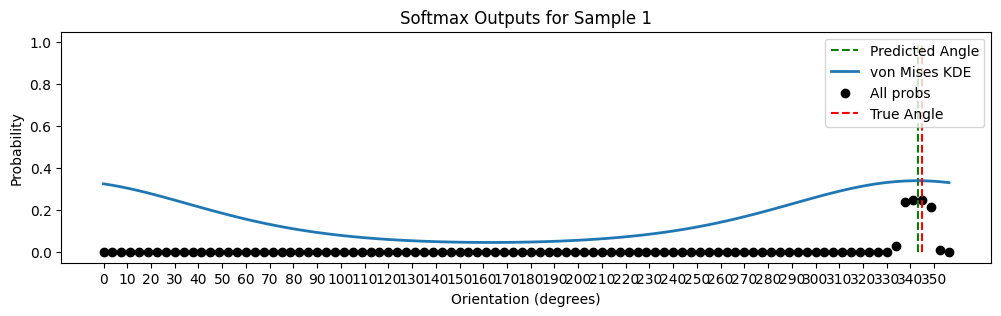

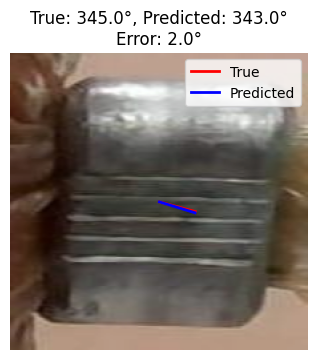

In [14]:
visualize_predictions(model, val_dataset, device, num_samples=1)

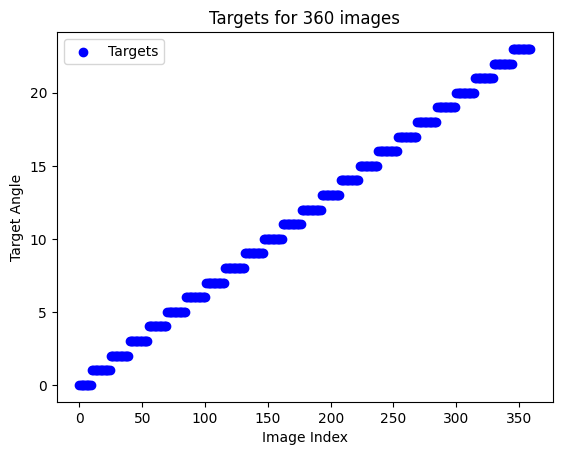

In [15]:
test_dataset = AngleDataset(
    root_dir=val_dir,
    transform=val_transforms,
    discretization_params={'N': N, 'M': 1}
)
import numpy as np

targets = []
for i in range(360):
    img, target, true_ang = test_dataset[i]
    targets.append(target)
plt.scatter(np.arange(len(targets)), targets, label='Targets', color='blue')
plt.title('Targets for 360 images')
plt.xlabel('Image Index')
plt.ylabel('Target Angle')
plt.legend()
plt.show()


True angle: 44.0
Target: 3


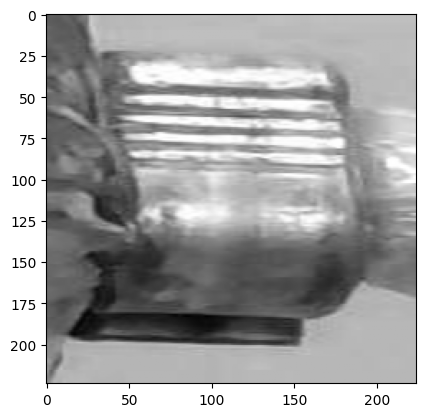

: 

In [ ]:
img, target, true_ang = test_dataset[46]
img = img.to('cpu')
plt.imshow(img.numpy()[0], cmap='gray')
print("True angle:", true_ang.item())
print("Target:", target.item())
